# 0.0 Import libraries

In [1]:
#Package import
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Any, Callable

# Progress bar
from tqdm import tqdm
from zipfile import ZipFile



# Scikit Learn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Helpers file
import helpers

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=13)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

# 0.1 Import data

In [4]:
features_train = pd.read_csv("project-data-raw/features_train.csv")
features_test = pd.read_csv("project-data-raw/features_test.csv")
features_val = pd.read_csv("project-data-raw/features_val.csv")
targets_train = pd.read_csv("project-data-raw/targets_train.csv")
targets_test = pd.read_csv("project-data-raw/targets_test.csv")
targets_val = pd.read_csv("project-data-raw/targets_val.csv")

# 1. Describe data

### 1.1 Shape of the datasets

In [ ]:
print(f'features_train.shape: {features_train.shape}')
print(f'targets_train.shape: {targets_train.shape} \n')
print(f'features_val.shape: {features_val.shape}')
print(f'targets_val.shape: {targets_val.shape} \n')
print(f'features_test.shape: {features_test.shape}')
print(f'targets_test.shape: {targets_test.shape} \n')

### 1.2 Main caracteristics of the features

In [ ]:
features_train.drop(columns=['Unnamed: 0']).describe()

In [ ]:
features_val.drop(columns=['Unnamed: 0']).describe()

In [ ]:
features_test.drop(columns=['Unnamed: 0']).describe()

In total, in the raw features data, there are 116 initial features :
- 105 features for the spectral acceleration, each corresponding to the spectral acceleration at a specific period ranging from 0.01 to 10 in [g]
- The geometric mean of the spectral accelerations in [g]: `sa_avg`
- The signification durations of the ground motions in [s]: `da5_75` and `da5_95`
- The filtered incremental velocity in [cm/s]: `fiv3`
- The magnitude in Richter scale: `magnitude`
- The distance at which the earthquake happened from the site where the ground motion was recorded in [km]: `distance_closest`
- The lowest frequency recorded in the ground motion in [Hz]: `lowest_usable_frequency`
- The ratio Sa(T1)/sa_avg in [-]: `sa_ratio`
- The ratio fiv3/sa_avg in [-]: `fiv3_ratio`
- A boolean indicating if the 'string velocity pulse' is present in the data: `is_pulselike`
- The ground motion corresponding to each features: `Ground Motion ID`

### 1.3 Random samples of the features

In [ ]:
features_train.drop(columns=['Unnamed: 0']).sample(5)

### 1.4 Random samples of the targets

In [ ]:
targets_train.drop(columns=['Unnamed: 0']).sample(5)

In the raw targets data, there are :
- The number by which the ground motion and its corresponding features were scaled to obtain the issue of the numerical analysis: `scale factor`
- The ground motion of the corresponding features for which the numerical analysis was performed: `Groumd Motion ID`
- The issue of the simulation `is_collapse`

# 2. Data merging


The dataset have to be merged together using `Ground Motion ID` to constitute the final dataset with the `Scaling factor` as a feature 

In [ ]:
df_X_train, df_y_train = helpers.dataset_processing(features_train, targets_train, testing=False)
df_X_val, df_y_val = helpers.dataset_processing(features_val, targets_val, testing=False)
df_X_test = helpers.dataset_processing(features_test, targets_test, testing=True)

In the merged features data, there are 115 resulting features :
- 105 features for the spectral acceleration, each corresponding to the spectral acceleration at a specific period ranging from 0.01 to 10
- The geometric mean of the spectral accelerations `sa_avg`
- The signification durations of the ground motions `da5_75` and `da5_95`
- The filtered incremental velocity `fiv3`
- The magnitude `magnitude`
- The distance at which the earthquake happened from the site where the ground motion was recorded: `distance_closest`
- The lowest frequency recorded in the ground motion: `lowest_usable_frequency`
- The ratio Sa(T1)/sa_avg: `sa_ratio`
- The ratio fiv3/sa_avg: `fiv3_ratio`
- A boolean indicating if the 'string velocity pulse' is present in the data: `is_pulselike`

In the merged targets data, there is
- The issue of the simulation `is_collapse`

In [ ]:
samples_train = df_X_train.shape[0]
samples_val = df_X_val.shape[0]
samples_test = df_X_test.shape[0]
samples_tot = samples_train + samples_val + samples_test

print(f'Traning dataset represents {samples_train/samples_tot*100:.2f} % of the total data available')
print(f'Validation dataset represents {samples_val/samples_tot*100:.2f} % of the total data available')
print(f'Testing dataset represents {samples_test/samples_tot*100:.2f} % of the total data available')

In [ ]:
print(f'features_train.shape: {df_X_train.shape}')
print(f'targets_train.shape: {df_y_train.shape} \n')
print(f'features_val.shape: {df_X_val.shape}')
print(f'targets_val.shape: {df_y_val.shape} \n')
print(f'features_test.shape: {df_X_test.shape}')

### Exporting the merged dataframes

Change `EXPORT` to `True` to export the merged data, otherwise leave it as `False`

In [ ]:
EXPORT = True

if EXPORT :
    df_X_train.to_csv("project-data-merged/df_X_train.csv")
    df_y_train.to_csv("project-data-merged/df_y_train.csv")

    df_X_val.to_csv("project-data-merged/df_X_val.csv")
    df_y_val.to_csv("project-data-merged/df_y_val.csv")

    df_X_test.to_csv("project-data-merged/df_X_test.csv")
    
    # create a ZipFile object
    zipObj = ZipFile('project-data-merged/data-interpolated.zip', 'w')

    # Add multiple files to the zip
    zipObj.write('project-data-merged/df_X_train.csv')
    zipObj.write('project-data-merged/df_y_train.csv')
    zipObj.write('project-data-merged/df_X_val.csv')
    zipObj.write('project-data-merged/df_y_val.csv')
    zipObj.write('project-data-merged/df_X_test.csv')

    # close the Zip File
    zipObj.close()

# 3. Data cleaning

### 3.1 Check for identical rows

In [ ]:
df_X_train, df_y_train = helpers.check_duplicates(df_X_train, df_y_train, 'Training')
df_X_val, df_y_val = helpers.check_duplicates(df_X_val, df_y_val, 'Validation')

### 3.3 Deal with missing data

Note: There are only missing values in the training dataset therefore this step is done only for the training and not for the validation nor the testing dataset

Replace column names, currently as strings, to float to be able to do the interpolation 

In [ ]:
Sa_T_floats = [float(x) for x in df_X_train.columns[:105]]
df_X_SaT = df_X_train.iloc[:,:105]
df_X_SaT.columns = Sa_T_floats

- Fill the missing values using a quadratic interpolation
- Values at the beginning and at the end are still `NaN`, hence a backward and forward fill is done

In [ ]:
df_X_SaT = df_X_SaT.interpolate(method='quadratic', axis = 1, limit_direction='both')
df_X_SaT = df_X_SaT.fillna(method = 'bfill',axis=1)
df_X_SaT = df_X_SaT.fillna(method = 'ffill',axis=1)

Replace whole Sa(T) with the new interpolated values

In [ ]:
df_X_train.iloc[:,:105] = df_X_SaT

Change `EXPORT` to `True` to export the interpolated data, otherwise leave it as `False`

In [ ]:
EXPORT = True

if EXPORT:
    df_X_train.to_csv("project-data-interpolated/df_X_train.csv")
    df_y_train.to_csv("project-data-interpolated/df_y_train.csv")

    df_X_val.to_csv("project-data-interpolated/df_X_val.csv")
    df_y_val.to_csv("project-data-interpolated/df_y_val.csv")

    df_X_test.to_csv("project-data-interpolated/df_X_test.csv")
    
    # create a ZipFile object
    zipObj = ZipFile('project-data-interpolated/data-interpolated.zip', 'w')

    # Add multiple files to the zip
    zipObj.write('project-data-interpolated/df_X_train.csv')
    zipObj.write('project-data-interpolated/df_y_train.csv')
    zipObj.write('project-data-interpolated/df_X_val.csv')
    zipObj.write('project-data-interpolated/df_y_val.csv')
    zipObj.write('project-data-interpolated/df_X_test.csv')

    # close the Zip File
    zipObj.close()

### 3.2 Deal with corrupted data

Remove the rows with `-999`

In [ ]:
df_X_train_red, df_y_train_red = helpers.check_corrupted(df_X_train, df_y_train, 'Training')
df_X_val_red, df_y_val_red = helpers.check_corrupted(df_X_val, df_y_val, 'Validation')

In [ ]:
df_X_train_red

# 4.Data visualization

### 4.1 Plot features
Check the influence of removing the `-999` on the distribution of the features

In [ ]:
features_to_plot = df_X_train_red.columns[-10:]
df_plot = df_X_train[features_to_plot]
df_plot_red = df_X_train_red[features_to_plot]

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(30,30))
fig.set_size_inches(20, 20)
list_axes = axes.flatten()
i=0

while i < df_plot.shape[1]:
    to_plot = df_plot.iloc[:, i]
    to_plot= to_plot.loc[~(to_plot == -999)]
    to_plot_red = df_plot_red.iloc[:, i]

    name = df_plot.iloc[:, i].name
    ax = list_axes[i]

    to_plot.hist(ax=ax, bins=20, grid=False, color=colors[-1], alpha=0.5, log=[False, True])
    to_plot_red.hist(ax=ax, bins=20, grid=False, color=colors[-2], alpha=0.5, log=[False, True])
    ax.set_title(str(name), size=25)
    ax.tick_params(axis='both', which='major', labelsize=15)
    
    if i % 3 == 0:
        ax.set_ylabel('Count', size=16)
        
    i += 1

plt.suptitle('Distributions of features columns (except spectral acceleration)', size=30)
plt.tight_layout(pad=5)
fig.legend(['Training set original', 'Training dataset without the -999'], fontsize=30, loc='lower right')
plt.show()

Description of the influence :
bablaalbalal

### 4.2 Plot the correlation and distribution of the data 

# 5. Data pre-processing

In [14]:
IMPORT_INTERP = True

if IMPORT_INTERP :
    df_X_train = pd.read_csv("project-data-interpolated-corrected/df_X_train.csv", index_col=0)
    df_X_test = pd.read_csv("project-data-interpolated-corrected/df_X_test.csv", index_col=0)
    df_X_val = pd.read_csv("project-data-interpolated-corrected/df_X_val.csv", index_col=0)
    df_y_train = pd.read_csv("project-data-interpolated-corrected/df_y_train.csv", index_col=0)
    df_y_val = pd.read_csv("project-data-interpolated-corrected/df_y_val.csv", index_col=0)

In [5]:
DROP = True 

if DROP :
    cols =['magnitude', 'distance_closest', 'lowest_usable_frequency']
    df_X_train.drop(columns=cols, inplace=True)
    df_X_val.drop(columns=cols, inplace=True)
    df_X_test.drop(columns=cols, inplace=True)

### 5.1 Boolean to numerical conversion

In [6]:
df_X_train = helpers.bool_to_num(df_X_train)
df_X_val = helpers.bool_to_num(df_X_val)
df_X_test = helpers.bool_to_num(df_X_test)

In [7]:
if IMPORT_INTERP:
    df_y_train = helpers.bool_to_num(df_y_train)
    df_y_val = helpers.bool_to_num(df_y_val)
    
if not(IMPORT_INTERP):   
    df_y_train = helpers.bool_to_num(pd.DataFrame(df_y_train))
    df_y_val = helpers.bool_to_num(pd.DataFrame(df_y_val))

### 5.2 Pandas to Numpy conversion

In [8]:
X_train = helpers.numpy_converter(df_X_train)
X_val = helpers.numpy_converter(df_X_val)
X_test = helpers.numpy_converter(df_X_test)

y_train_final = helpers.numpy_converter(df_y_train)
y_val_final = helpers.numpy_converter(df_y_val)

### 5.3 Normalization

In [9]:
sc = StandardScaler()
sc.fit(X_train)
X_train_final = sc.transform(X_train)
X_val_final = sc.transform(X_val)
X_test_final = sc.transform(X_test)

### 5.4 Principal Component Analysis

Fit and tranform the data to reduce the number of features (`features` to `PC`)

#### PCA with all the features and without the -999 rows

#### PCA with the Sa(t) and without the columns contained -999

# 6. Machine Learning Models

## Neural Network

### 6.1 Define the hyperparameters

In [10]:
#number times that the learning algorithm will work through the entire training dataset
epochs = 30     

#number of samples to work through before updating the internal model parameters
batch_size =128  #if 64 slower but similar results

#
lr = 0.01 

#
weight_decay = 1e-5 #if 1e-1 less overfitting and curves loss are closer but worst results

#
batch_norm_momentum = 0.1 #not good if bigger


#randomly zeroes some of the elements of the input tensor during training with probability=dropout using a Bernoulli distribution
dropout=0.1    #small is better 

#
coef_sheduler = 0.60 #0.60 best results, if increased -->  training accuracy above 0.83 but increases overfitting so worst final result

### 6.2 Data as a PyTorch Dataset class

#### Define the Dataset class for each dataset

In [11]:
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [12]:
class ValData(Dataset):
    def __init__(self, X_data, y_data): #for initialization operations (reading and preprocess data)
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):  #returns data in batches
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [13]:
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

#### Create the data classes

In [14]:
train_data = TrainData(torch.FloatTensor(X_train_final), torch.FloatTensor(y_train_final))
val_data = ValData(torch.FloatTensor(X_val_final), torch.FloatTensor(y_val_final))
test_data = TestData(torch.FloatTensor(X_test_final))

#### Load the data as DataLoader class

To be able to use mini-batch for the gradient descent, the data must be configured with the DataLoader \
The `batch_size` is defined as a hyperparameter at the beginning of the section

In [15]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=X_val_final.shape[0], shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)

### 6.3 Model Setup

#### 6.3.1 The Model

#### Define the model class

In [16]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.l1 = nn.Linear(X_train_final.shape[1], 80)
        self.bnm1 = nn.BatchNorm1d(80, momentum=batch_norm_momentum)
        self.l2 = nn.Linear(80, 30)
        self.bnm2 = nn.BatchNorm1d(30, momentum=batch_norm_momentum)
        self.l3 = nn.Linear(30, 20)
        self.bnm3 = nn.BatchNorm1d(20, momentum=batch_norm_momentum)
        self.l4 = nn.Linear(20, 1)
       
        
        self.dropout = nn.Dropout(dropout)
        
        self.Relu = nn.ReLU()
        
        self.initialize_weights()

    def forward(self, x):
        x = self.Relu(self.l1(x))
        x = self.dropout(x)
        x = self.bnm1(x)
        x = self.Relu(self.l2(x))
        x = self.dropout(x)
        x = self.bnm2(x)
        x = self.Relu(self.l3(x))
        x = self.dropout(x)
        x = self.bnm3(x)
        y_pred = self.l4(x)
        return y_pred
    
    def initialize_weights(self):  
        for m in self.modules():
            if isinstance(m,nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias,0)

#### Create the model from the class

In [17]:
model = Model()

Use the GPU if available otherwise the CPU

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Move model on the GPU if active

In [19]:
model.to(device)

Model(
  (l1): Linear(in_features=112, out_features=80, bias=True)
  (bnm1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=80, out_features=30, bias=True)
  (bnm2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=30, out_features=20, bias=True)
  (bnm3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (Relu): ReLU()
)

#### 6.3.2 Specify the optimizer 

Write about Adam optimizer, maybe add few formulas to describe or idk

In [20]:
optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=weight_decay)

#### 6.3.3 Specify the loss function

write also about this loss function

In [21]:
criterion = nn.BCEWithLogitsLoss()

#### 6.3.4 Adjust learning rate

explain chosen scheduler etc 

In [22]:
lambda_scheduler = lambda epoch: coef_sheduler ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_scheduler)


#### 6.3.4 Accuracy calculation

In [23]:
def b_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc * 100
    
    return acc

### 6.4 Training

#### Create a function to train the model and validate it at each epoch

In [24]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, val_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):
    accs_train = []
    losses_train = []
    accs_val = []
    losses_val = []
    
    for e in range(1, epochs+1):
        epoch_loss_train = 0
        epoch_acc_train = 0
        epoch_loss_val = 0
        epoch_acc_val = 0
        
        #TRAINING LOOP FOR EACH EPOCH
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            acc_train = b_acc(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()
            epoch_acc_train += acc_train.item()
            
        scheduler.step()
        
        losses_train.append(epoch_loss_train/len(train_loader))
        accs_train.append(epoch_acc_train/len(train_loader))
        
    
        #VALIDATION LOOP FOR EACH EPOCH
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_val_pred = model(X_batch)

                loss_val = criterion(y_val_pred, y_batch)
                acc_val = b_acc(y_val_pred, y_batch)

                epoch_loss_val += loss_val.item()
                epoch_acc_val += acc_val.item()

            losses_val.append(epoch_loss_val/len(val_loader))
            accs_val.append(epoch_acc_val/len(val_loader))          
        
        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss_train/len(train_loader):.5f} | Val Loss: {epoch_loss_val/len(val_loader):.5f} | Train Acc: {epoch_acc_train/len(train_loader):.3f} | Val Acc: {epoch_acc_val/len(val_loader):.3f}')
    return losses_train, accs_train, losses_val, accs_val

#### Train the model

In [25]:
loss_train, acc_train, loss_val, acc_val =  train(model, train_loader, val_loader, criterion, optimizer, epochs)

Epoch 001: | Train Loss: 0.41517 | Val Loss: 0.39412 | Train Acc: 80.476 | Val Acc: 80.374
Epoch 002: | Train Loss: 0.39314 | Val Loss: 0.38400 | Train Acc: 81.466 | Val Acc: 81.608
Epoch 003: | Train Loss: 0.38709 | Val Loss: 0.38820 | Train Acc: 81.820 | Val Acc: 81.011
Epoch 004: | Train Loss: 0.38184 | Val Loss: 0.38141 | Train Acc: 81.951 | Val Acc: 81.290
Epoch 005: | Train Loss: 0.37782 | Val Loss: 0.37892 | Train Acc: 82.227 | Val Acc: 81.967
Epoch 006: | Train Loss: 0.37467 | Val Loss: 0.38439 | Train Acc: 82.301 | Val Acc: 81.887
Epoch 007: | Train Loss: 0.37375 | Val Loss: 0.37928 | Train Acc: 82.358 | Val Acc: 81.847
Epoch 008: | Train Loss: 0.37221 | Val Loss: 0.38228 | Train Acc: 82.505 | Val Acc: 81.688
Epoch 009: | Train Loss: 0.37139 | Val Loss: 0.38243 | Train Acc: 82.524 | Val Acc: 81.807
Epoch 010: | Train Loss: 0.37098 | Val Loss: 0.37941 | Train Acc: 82.532 | Val Acc: 82.365
Epoch 011: | Train Loss: 0.37064 | Val Loss: 0.37849 | Train Acc: 82.610 | Val Acc: 81.688

### 6.5 Validation

Plot the evolution of the loss and the accuracy with the epoch

Text(0, 0.5, 'Accuracy')

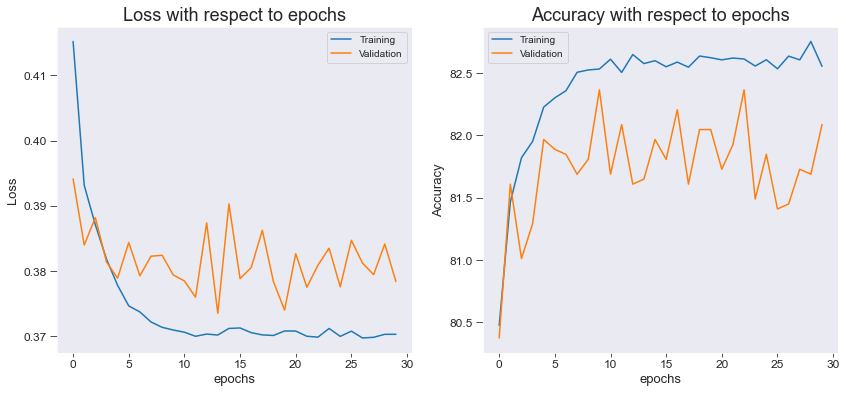

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

ax[0].set_title('Loss with respect to epochs')
ax[0].plot(loss_train)
ax[0].plot(loss_val)
ax[0].legend(['Training', 'Validation'])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title('Accuracy with respect to epochs')
ax[1].plot(acc_train)
ax[1].plot(acc_val)
ax[1].legend(['Training', 'Validation'])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')

### 6.6 Testing

Function to test the model

In [27]:
def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):
    model.eval()
        
    y_pred_test = [] #initialize vector with predictions
   
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_test.append(y_pred_tag.cpu().numpy())

    y_pred_test = [int(a.squeeze().tolist()) for a in y_pred_test]
    return y_pred_test

Test the model

In [28]:
label = pd.DataFrame(test(model,test_loader))
label.columns = ["label"]

Overview of the results

In [29]:
count0 = (label['label'] == 0).sum()
count1 = (label['label'] == 1).sum()
print("Number of predicted 0 is: {} ".format(count0))
print("Number of predicted 1 is: {} ".format(count1))

Number of predicted 0 is: 23594 
Number of predicted 1 is: 24758 


Export the results as .csv

In [ ]:
EXPORT = True
if EXPORT:
    label.to_csv("out/label.csv", index = False, header = True)